In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import random

In [2]:
# Cargar dataset
df = pd.read_csv('../datos_simulados/datos_final.csv')

# Clasificación de variables
variables_categoricas = [
    'Clase', 'Pieza', 'Superficie_1', 'Superficie_2', 'Superficie_3', 'Superficie_4',
    'Superficie_5', 'Estado_cavidad', 'Tecnica', 'Tipo_resina', 'Ajuste_margen'
]

variables_numericas = [
    'Indice_contraccion_%', 'Tamanio_cavidad_mm', 'Peso_sobrante_mg', 'Margen_cavo_mm'
]

# Codificar variables categóricas
df_codificado = pd.get_dummies(df[variables_categoricas + variables_numericas])

# Definir X (entradas) e y (salida)
X = df_codificado
y = df['Peso_resina_inicial_mg']

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

       Indice_contraccion_%  Tamanio_cavidad_mm  Peso_sobrante_mg  \
count          28800.000000        28800.000000      28800.000000   
mean               2.496910           31.011467         26.630315   
std                0.868352           27.939867         24.940825   
min                1.000000            2.000000          1.040000   
25%                1.750000            8.500000         11.080000   
50%                2.500000           21.500000         19.280000   
75%                3.250000           46.000000         33.150000   
max                4.000000          140.000000        224.260000   

       Margen_cavo_mm  
count    28800.000000  
mean         0.032669  
std          0.114532  
min         -0.200000  
25%         -0.060000  
50%          0.050000  
75%          0.130000  
max          0.200000  


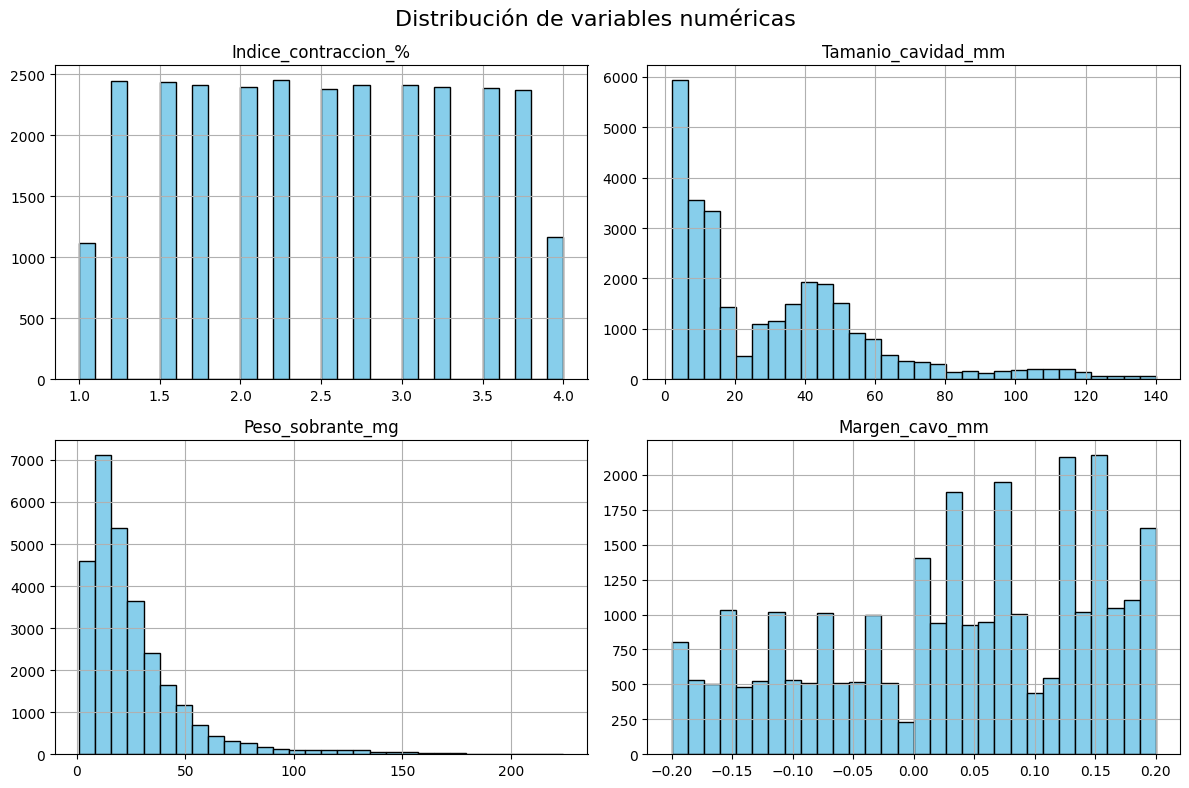

In [3]:
# Paso 4a: Estadística descriptiva y distribución de variables numéricas
print(df[variables_numericas].describe())

# Histogramas
df[variables_numericas].hist(
    figsize=(12, 8),
    bins=30,
    color='skyblue',
    edgecolor='black'
)
plt.suptitle("Distribución de variables numéricas", fontsize=16)
plt.tight_layout()
plt.show()


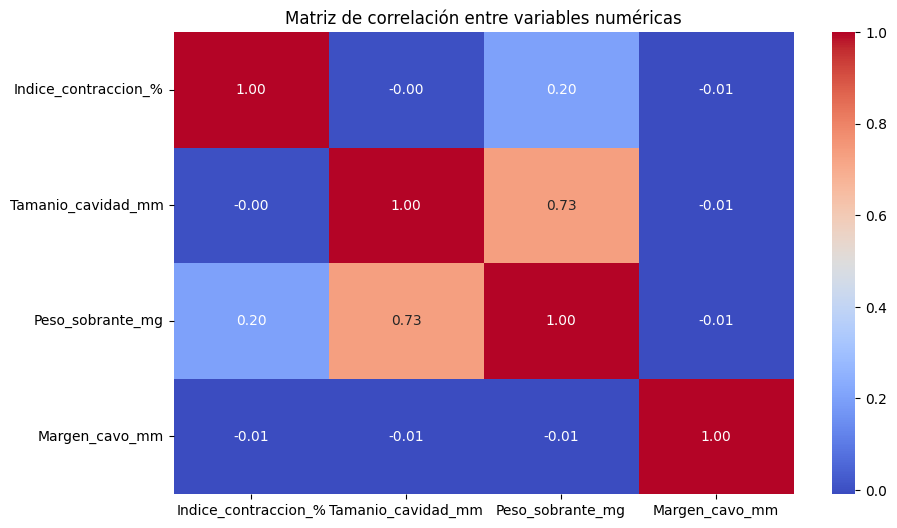

In [4]:
# Paso 4b: Correlación de variables numéricas
plt.figure(figsize=(10, 6))
sns.heatmap(df[variables_numericas].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre variables numéricas")
plt.show()


In [5]:
# Paso 5a: Verificación y tratamiento de valores nulos
print("Valores nulos por columna:")
print(df.isnull().sum())

# Si hay nulos en variables numéricas → reemplazar con mediana
for col in variables_numericas:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

# Paso 5b: Eliminación de duplicados exactos
df.drop_duplicates(inplace=True)

# Paso 5c: Identificación de outliers con IQR
for col in variables_numericas:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[col] < limite_inferior) | (df[col] > limite_superior)]
    print(f"{col}: {len(outliers)} outliers detectados")


Valores nulos por columna:
Clase                     0
Pieza                     0
Superficie_1              0
Superficie_2              0
Superficie_3              0
Superficie_4              0
Superficie_5              0
Tamanio_cavidad_mm        0
Estado_cavidad            0
Tecnica                   0
Tipo_resina               0
Indice_contraccion_%      0
Peso_resina_inicial_mg    0
Peso_sobrante_mg          0
Margen_cavo_mm            0
Ajuste_margen             0
dtype: int64
Indice_contraccion_%: 0 outliers detectados
Tamanio_cavidad_mm: 1061 outliers detectados
Peso_sobrante_mg: 1766 outliers detectados
Margen_cavo_mm: 0 outliers detectados


Valores nulos después del tratamiento:
Clase                     0
Pieza                     0
Superficie_1              0
Superficie_2              0
Superficie_3              0
Superficie_4              0
Superficie_5              0
Tamanio_cavidad_mm        0
Estado_cavidad            0
Tecnica                   0
Tipo_resina               0
Indice_contraccion_%      0
Peso_resina_inicial_mg    0
Peso_sobrante_mg          0
Margen_cavo_mm            0
Ajuste_margen             0
dtype: int64


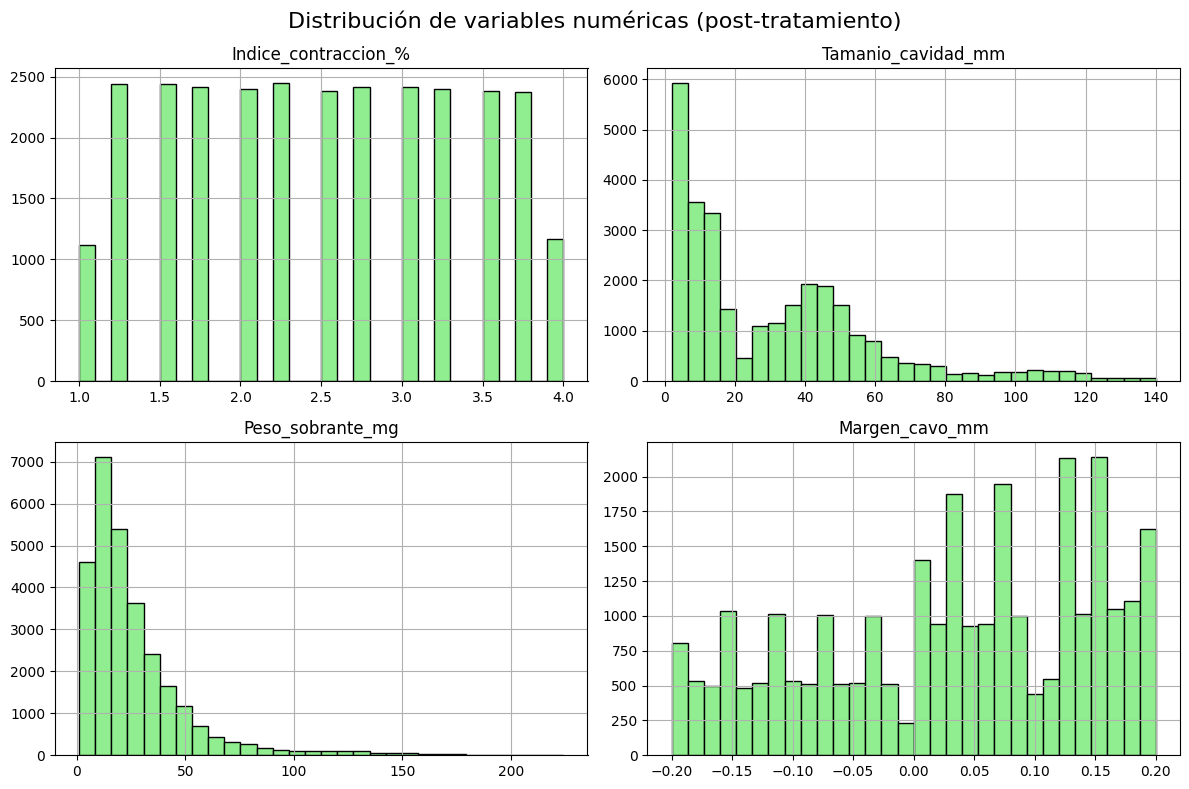

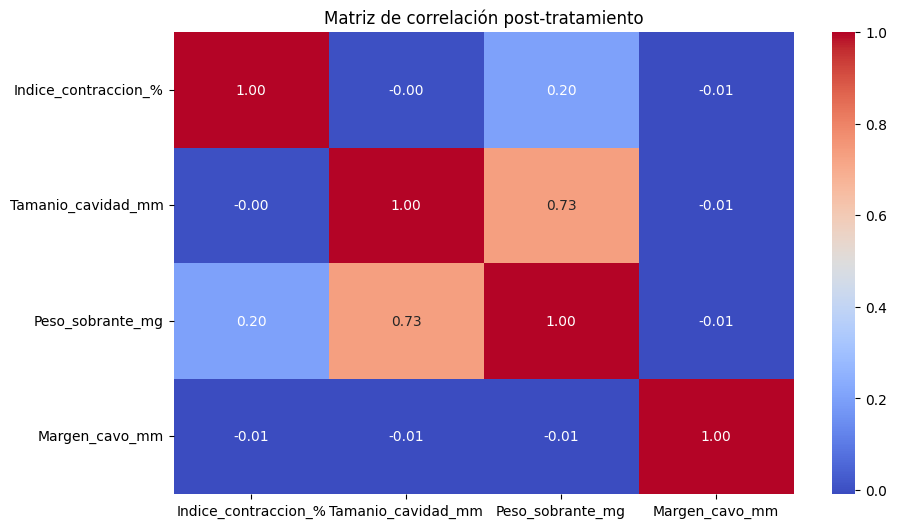

In [6]:
# Paso 6a: Validar que ya no existen datos nulos
print("Valores nulos después del tratamiento:")
print(df.isnull().sum())

# Paso 6b: Verificar cambios en las distribuciones
df[variables_numericas].hist(
    figsize=(12, 8),
    bins=30,
    color='lightgreen',
    edgecolor='black'
)
plt.suptitle("Distribución de variables numéricas (post-tratamiento)", fontsize=16)
plt.tight_layout()
plt.show()

# Paso 6c: Comparar correlaciones para detectar cambios artificiales
plt.figure(figsize=(10, 6))
sns.heatmap(df[variables_numericas].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación post-tratamiento")
plt.show()


In [7]:
# Normalizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear el modelo MLP
modelo_mlp = Sequential()
modelo_mlp.add(Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)))
modelo_mlp.add(Dense(32, activation='relu'))
modelo_mlp.add(Dense(16, activation='relu'))
modelo_mlp.add(Dense(1))  # salida para regresión

# Configurar EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compilar modelo
modelo_mlp.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar modelo
historial = modelo_mlp.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    #callbacks=[early_stop]
)


C:\Users\mau_a\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 50499.0508 - mae: 146.8214 - val_loss: 2253.8933 - val_mae: 38.0350
Epoch 2/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1954.7372 - mae: 35.1109 - val_loss: 1323.2915 - val_mae: 28.2718
Epoch 3/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1205.6493 - mae: 27.0807 - val_loss: 1007.1885 - val_mae: 24.2358
Epoch 4/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1022.6121 - mae: 24.2767 - val_loss: 944.8665 - val_mae: 23.2819
Epoch 5/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 928.4498 - mae: 22.9112 - val_loss: 871.6938 - val_mae: 22.3221
Epoch 6/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 829.1094 - mae: 21.3574 - val_loss: 759.5711 - val_mae: 20.2208
Epoch 7/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 734.1600 - mae: 19.8150 - val_loss: 668.3051 - val_mae: 18.8826
Epoch 8/100
576/576 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 640.6666 - mae: 18.3217 - val_loss: 625.1890 - val_mae:

In [8]:
# Evaluar en el conjunto de prueba
test_mse, test_mae = modelo_mlp.evaluate(X_test_scaled, y_test, verbose=0)
print(f"MAE en prueba: {test_mae:.2f}")
print(f"MSE en prueba: {test_mse:.2f}")

#Métricas
y_pred = modelo_mlp.predict(X_test_scaled)
mse  = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.2f}")


MAE en prueba: 14.55
MSE en prueba: 502.68
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
RMSE: 22.42
MAE : 14.55
R²  : 0.99


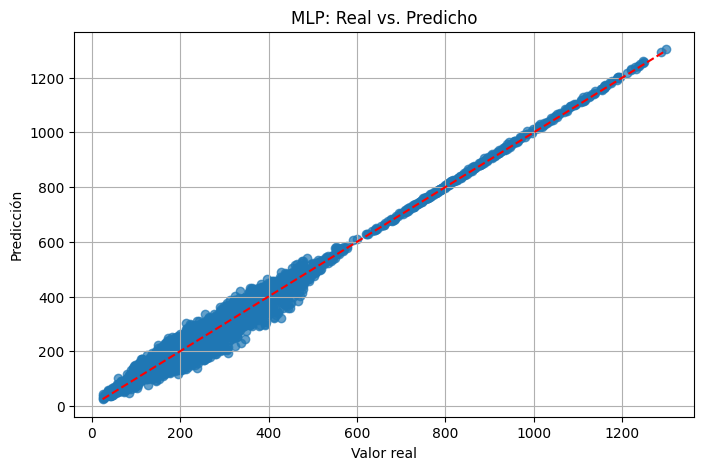

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("MLP: Real vs. Predicho")
plt.grid(True)
plt.show()

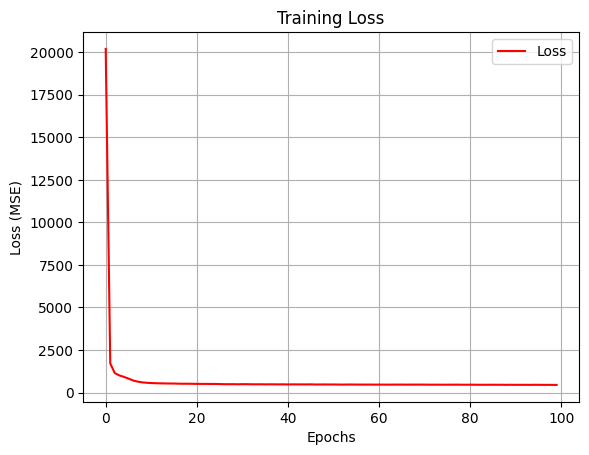

In [10]:
# Recuperar la pérdida por época durante el entrenamiento
train_loss_history = historial.history['loss']
epochs = range(len(train_loss_history))

# Gráfica general de pérdida
plt.plot(epochs, train_loss_history, 'r')
plt.title('Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend(["Loss"])
plt.grid(True)
plt.show()